In [3]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from scipy import sparse
import pickle

# Parameters
n = 20          # Number of nodes (small for toy model)
m = 2           # Dimensions per node (Rulkov: u, v)
time = 500      # Time steps for data
transient = 10000  # Transient steps to discard
beta = 4.1      # Rulkov parameter for chaotic dynamics
mu = 0.001      # Rulkov parameter
sigma = 0.001   # Rulkov parameter
C = 0.1         # Coupling strength (weak)
gamma = 0.001   # Noise amplitude
eta = 0.2       # Weight variation for network edges


# Load the saved pickle file
filename = f"../data/statistics_data/statistics_gamma_{gamma}.pkl"
with open(filename, 'rb') as f:
    storage = pickle.load(f)

# Extract data (first realization)
A = storage["adj_matrix"][0]
L = storage["laplacian_matrix"][0]
delta = storage["delta"][0]
x = storage["data"][0]
dist_matrix = storage["dist_matrix"][0]
Fx = storage["Fx"][0]
Y_hub = storage["Y_hub"][0]
Y = storage["Y"][0]
L_pred = storage["predicted_laplacian"][0]

# Compute hub_id
s = np.sum(dist_matrix, axis=1)
hub_id = np.argmax(s)
print(f"Hub ID: {hub_id}")

# Function to simulate with a given Laplacian
def simulate_with_L(L_used, delta, transient, time, beta, mu, sigma, C, h, gamma, x_noise, n, m):
    def rulkov_map(x):
        x = x.reshape(n, m).T
        return np.asarray([
            beta / (1 + x[0]**2) + x[1],
            x[1] - mu * x[0] - sigma
        ]).T.flatten()

    def net_dynamics(x):
        return rulkov_map(x) - (C / delta) * sparse.kron(L_used, h).dot(x) + x_noise * gamma * np.random.uniform(-1, 1, n * m)

    x0 = np.random.uniform(0.0, 1.0, n * m)
    for _ in range(transient):
        x0 = rulkov_map(x0)
    for _ in range(transient):
        x0 = net_dynamics(x0)
    x_sim = np.zeros((n * m, time))
    x_sim[:, 0] = x0
    for t in range(time - 1):
        x_sim[:, t + 1] = net_dynamics(x_sim[:, t])
    return x_sim.reshape(n, m, time)

# Adjust L_pred for simulation (scale and sign to match original L)
L_recon = - (delta / C) * L_pred

Hub ID: 12


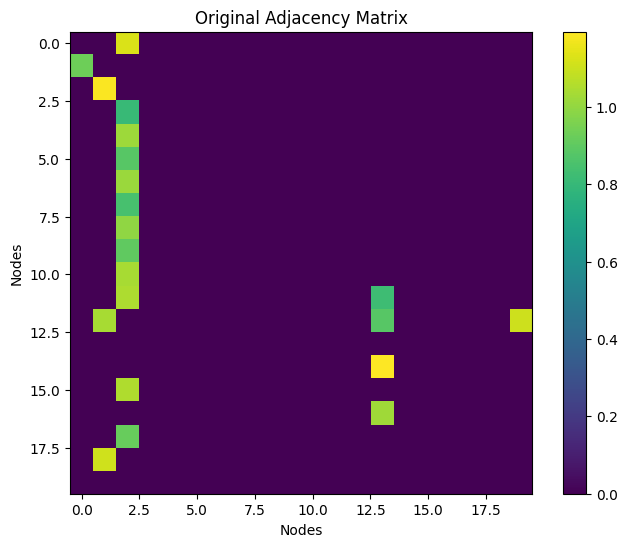

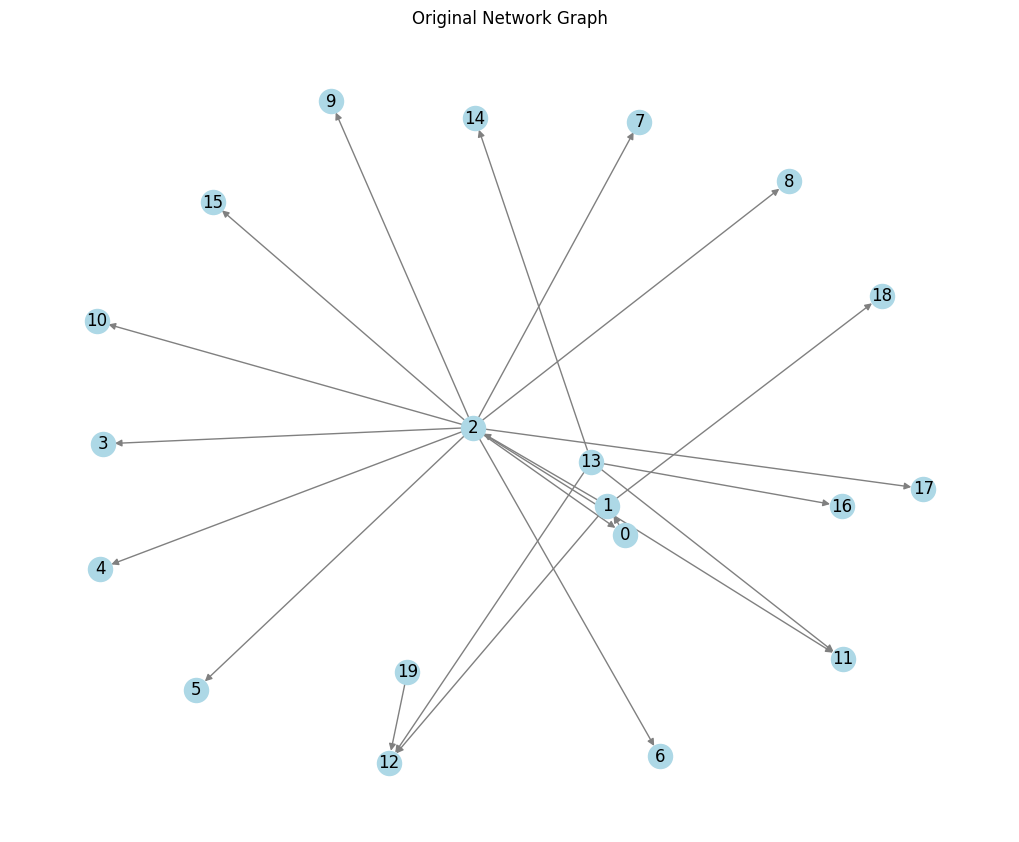

In [5]:
# Heatmap of Adjacency Matrix
plt.figure(figsize=(8, 6))
plt.imshow(A, cmap='viridis')
plt.colorbar()
plt.title('Original Adjacency Matrix')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

# Graph Visualization
G = nx.from_numpy_array(A.T, create_using=nx.DiGraph)  # Transpose for NetworkX convention
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
plt.title('Original Network Graph')
plt.show()

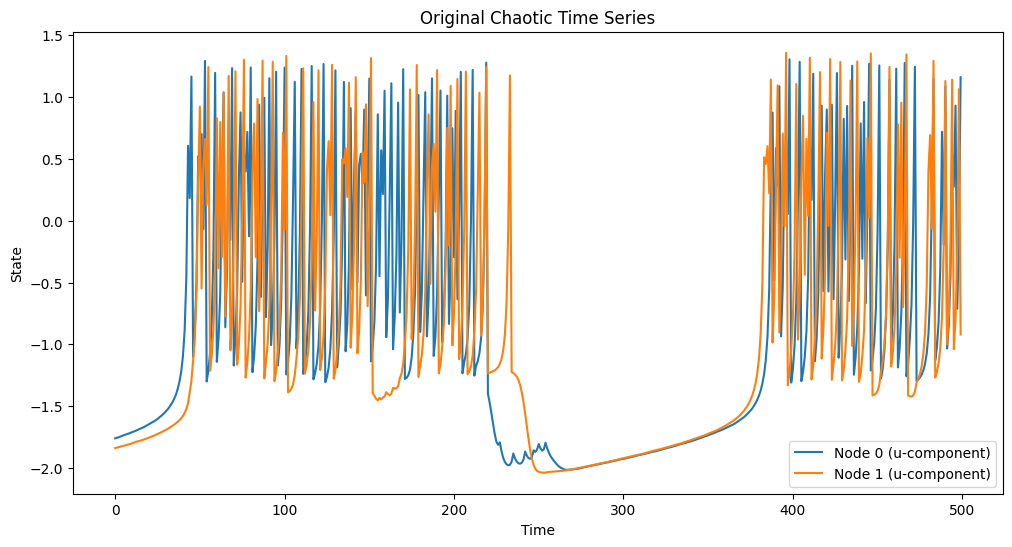

In [11]:
plt.figure(figsize=(12, 6))
for i in range(min(2, n)):
    plt.plot(x[i, 0, :], label=f'Node {i} (u-component)')
plt.title('Original Chaotic Time Series')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

# Reconstructed network

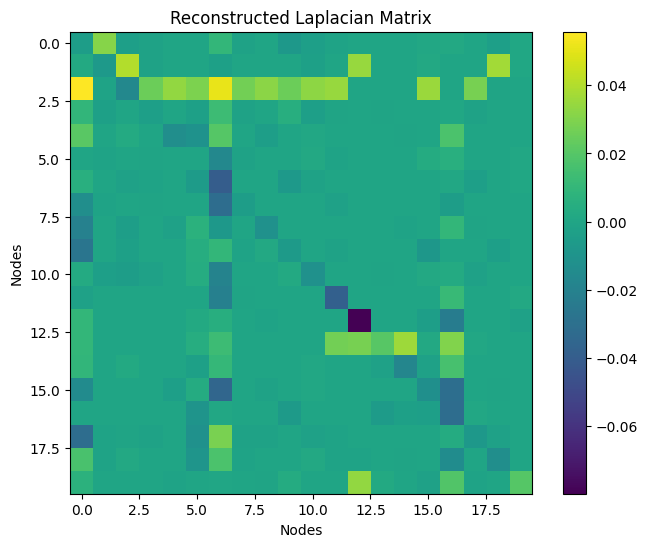

In [12]:
plt.figure(figsize=(8, 6))
plt.imshow(L_pred, cmap='viridis')
plt.colorbar()
plt.title('Reconstructed Laplacian Matrix')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

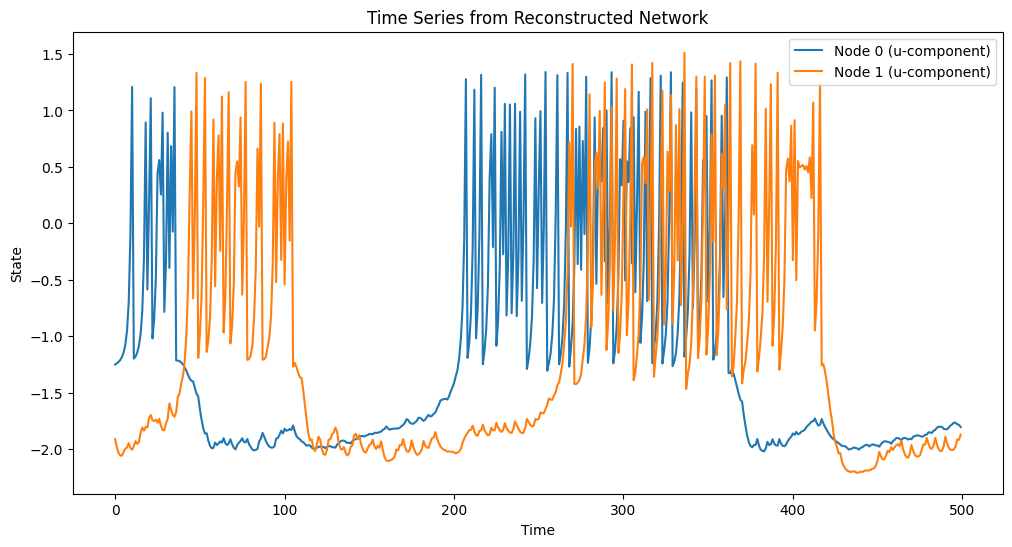

In [17]:
# Generate time series from reconstructed
n = 20
m = 2
# Coupling matrix h (x-directional)
h = np.eye(m)
h[1, 1] = 0

# Define x_noise before calling the function
x_noise = np.zeros(n * m)
x_noise[::2] = 1  # Noise on u-component (even indices: u1, v1, u2, v2, ...)


x_reconstructed = simulate_with_L(L_recon, delta, transient, time, beta, mu, sigma, C, h, gamma, x_noise, n, m)

plt.figure(figsize=(12, 6))
for i in range(min(2, n)):
    plt.plot(x_reconstructed[i, 0, :], label=f'Node {i} (u-component)')
plt.title('Time Series from Reconstructed Network')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

# Comparison

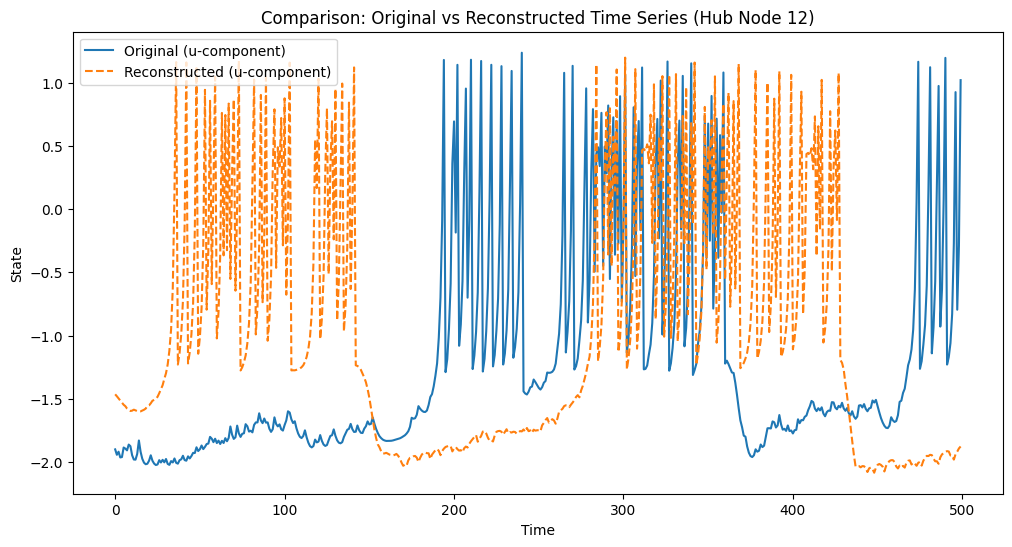

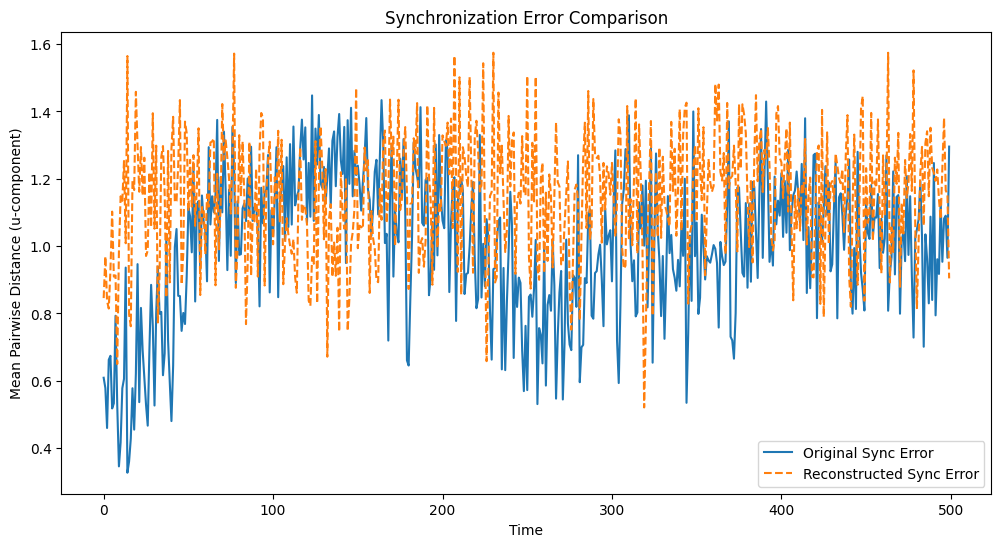

In [18]:
# Comparison for hub node
plt.figure(figsize=(12, 6))
plt.plot(x[hub_id, 0, :], label='Original (u-component)')
plt.plot(x_reconstructed[hub_id, 0, :], label='Reconstructed (u-component)', linestyle='--')
plt.title(f'Comparison: Original vs Reconstructed Time Series (Hub Node {hub_id})')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

# Synchronization error function
def sync_error(x):
    sync_err = []
    for t in range(x.shape[2]):
        dists = pdist(x[:, 0, t].reshape(-1, 1))
        sync_err.append(np.mean(dists))
    return np.array(sync_err)

original_sync = sync_error(x)
reconstructed_sync = sync_error(x_reconstructed)

plt.figure(figsize=(12, 6))
plt.plot(original_sync, label='Original Sync Error')
plt.plot(reconstructed_sync, label='Reconstructed Sync Error', linestyle='--')
plt.title('Synchronization Error Comparison')
plt.xlabel('Time')
plt.ylabel('Mean Pairwise Distance (u-component)')
plt.legend()
plt.show()

Keys in storage: ['adj_matrix', 'laplacian_matrix', 'delta', 'data', 'dist_matrix', 'Fx', 'Y_hub', 'Y', 'predicted_laplacian']
Number of realizations: 1


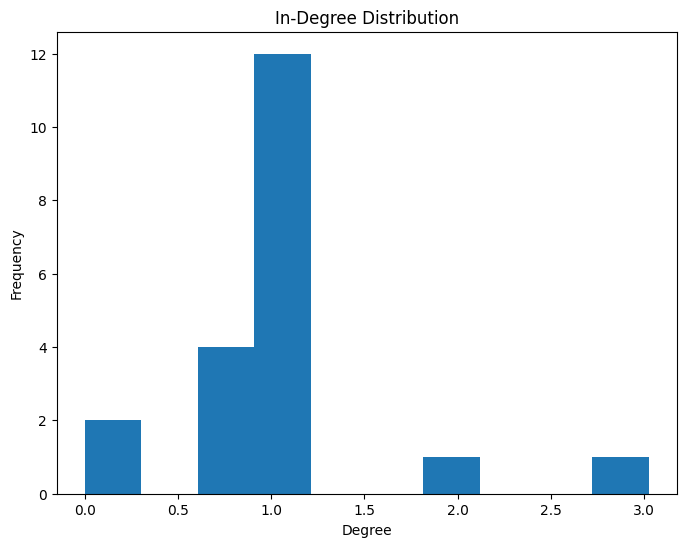

RMSE for single realization: 0.35384628174298616


In [19]:
# Print keys and stats
print("Keys in storage:", list(storage.keys()))
print("Number of realizations:", len(storage["adj_matrix"]))

# Example: Degree distribution
degrees = np.sum(A, axis=1)  # In-degrees from A
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=10)
plt.title('In-Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

# If multiple realizations, average RMSE
if len(storage["adj_matrix"]) > 1:
    rmse_values = []
    for i in range(len(storage["adj_matrix"])):
        L_i = storage["laplacian_matrix"][i]
        L_pred_i = storage["predicted_laplacian"][i]
        delta_i = storage["delta"][i]
        rmse_i = np.sqrt(np.mean((L_i - (C / delta_i) * L_pred_i)**2))
        rmse_values.append(rmse_i)
    print("Average RMSE:", np.mean(rmse_values))
else:
    print("RMSE for single realization:", np.sqrt(np.mean((L - (C / delta) * L_pred)**2)))